## Converting MeerKAT observation files to a measurement set
Convertion scripts are installed into the python path by `katdal`   
For all available options: `mvftoms.py -h`

`mvftoms.py ../example-data/1548417874/1548417874/1548417874_sdp_l0.full.rdb -o mkat_cal_im_full.ms -f -a -C '163,3885' --quack=3`     
`mvftoms.py ../example-data/1548417874/1548417874/1548417874_sdp_l0.full.rdb -o mkat_cal_im_section.ms -f -a -C '2150,3150'--quack=3`

**Note: pre-flagging is generally only good to use for continuum imaging and not for spectral lines, since it will flag out the science lines.**   
For imaging the calibrators, we will select to pre-flag the data during conversion.


## Measurement set and CASA

A measurement set is read as a "file" but is represented as a directory containing "tables" with telescope and observation information. A quick way to inspect the format is to list the unpacked directory

In [57]:
ls ../example-data/mkat_cal_im_section.ms

ANTENNA/           PROCESSOR/        table.f2_TSM0  table.f7
DATA_DESCRIPTION/  SOURCE/           table.f3       table.f7_TSM0
FEED/              SPECTRAL_WINDOW/  table.f3_TSM0  table.f8
FIELD/             STATE/            table.f4       table.f8_TSM0
FLAG_CMD/          table.dat         table.f4_TSM0  table.f9
HISTORY/           table.f0          table.f5       table.f9_TSM0
OBSERVATION/       table.f1          table.f5_TSM0  table.info
POINTING/          table.f1_TSM0     table.f6       table.lock
POLARIZATION/      table.f2          table.f6_TSM0


**Important: Even though you can access the CASA measurement set as a normal directory with files, NEVER change any of the files or directories inside this measurement set (.ms) directory outside of CASA. This will break the expected structure and CASA will be unable to read and process the data.**

It is customary to refer to CASA measurement sets as "files" with a ".ms" extension

In [58]:
msfile='../example-data/mkat_cal_im_section.ms'

Use the `tasklist` command to list available CASA functions.

In [59]:
print casa['build']['version']

tasklist()

5.5.0-149  
Available tasks, organized by category (experimental tasks in parenthesis ()
  deprecated tasks in curly brackets {}).


Import/export       Information         Editing             Manipulation      
------------------  ------------------  ------------------  ------------------
exportasdm          asdmsummary         fixplanets          concat            
exportfits          imhead              fixvis              conjugatevis      
exportuvfits        imreframe           flagcmd             cvel              
importasap          imstat              flagdata            fixvis            
importasdm          imval               flagmanager         hanningsmooth     
importatca          listcal             msview              imhead            
importfits          listfits            plotms              mstransform       
importfitsidi       listhistory                             oldstatwt         
importmiriad        listobs                                 partition        

## Observation calibration with CASA

A CASA measurement set contains not only the data of the observation, but also metadata about the observatory, as well as additional info related to the observation that is needed to analyse and calibrate the data. This information can be viewed (compare the output with the `katdal` header display):

In [60]:
listobs(vis=msfile)

           MeasurementSet Name:  /home/jupyter/example-data/mkat_cal_im_section.ms      MS Version 2
   Observer: Lindsay     Project: 20190125-0012  
Observation: MeerKAT
Data records: 144       Total elapsed time = 191.919 seconds
   Observed from   25-Jan-2019/12:05:08.4   to   25-Jan-2019/12:08:20.3 (UTC)

   ObservationID = 0         ArrayID = 0
  Date        Timerange (UTC)          Scan  FldId FieldName             nRows     SpwIds   Average Interval(s)    ScanIntent
  25-Jan-2019/12:05:08.4 - 12:08:20.3     1      0 PKS1934-63                 144  [0]  [8] [UNKNOWN]
           (nRows = Total number of rows per scan) 
Fields: 1
  ID   Code Name                RA               Decl           Epoch   SrcId      nRows
  0    T    PKS1934-63          19:39:25.030000 -63.42.45.70000 J2000   0            144
Spectral Windows:  (1 unique spectral windows and 1 unique polarization setups)
  SpwID  Name   #Chans   Frame   Ch0(MHz)  ChanWid(kHz)  TotBW(kHz) CtrFreq(MHz)  Corrs          
 

True

Show log 2019-06-18 09:03:36	INFO	listobs::::	
 2019-06-18 09:03:36	INFO	listobs::::+	##########################################
 2019-06-18 09:03:36	INFO	listobs::::+	##### Begin Task: listobs #####
 2019-06-18 09:03:36	INFO	listobs::::	listobs(vis="../example-data/mkat_cal_im_section.ms",selectdata=True,spw="",field="",antenna="",
 2019-06-18 09:03:36	INFO	listobs::::+ uvrange="",timerange="",correlation="",scan="",intent="",
 2019-06-18 09:03:36	INFO	listobs::::+ feed="",array="",observation="",verbose=True,listfile="casapy_temp.txt",
 2019-06-18 09:03:36	INFO	listobs::::+ listunfl=False,cachesize=50,overwrite=True)
 2019-06-18 09:03:36	INFO	listobs::ms::summary	Writing output to file: casapy_temp.txt
 2019-06-18 09:03:36	INFO	listobs::MSMetaData::_computeScanAndSubScanProperties Computing scan and subscan properties...
 2019-06-18 09:03:36	INFO	listobs::::	##### End Task: listobs #####
 2019-06-18 09:03:36	INFO	listobs::::+	##########################################

Useful information: targets (fields) observed, and in which spectral windows (Spw). Whether the observation contains a single setup or various spectral resolutions: number channels, total bandwidth, center frequency, correlator product per spectral window. As well as, number of antennas and which antennas was used.

Firstly, try to identify which sources are calibrators and which are targets. This will be indicated in the science proposal, but can also be inferred from the targets. Flux and bandpass calibrators will have only a few observations, gain/phase calibrators will be intermittent with the science observations, but will be observed for shorter intervals and will typically be within 15 degrees of a science target. For flux and bandpass calibrators, only verify that they were up some time during the observation (if more than one select the best one to use). For gain calibrators it is a little more complex, select a calibrator close (approx 15 to 10 degrees) to the target and apply that calibration solution to the target.

Number of points being plotted: 4


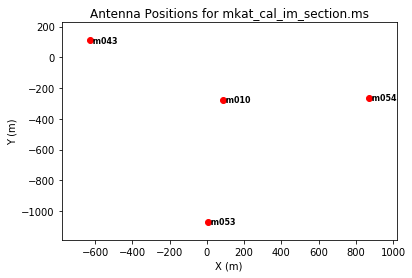

Show log 2019-06-18 09:03:36	INFO	plotants::::	
 2019-06-18 09:03:36	INFO	plotants::::+	##########################################
 2019-06-18 09:03:36	INFO	plotants::::+	##### Begin Task: plotants #####
 2019-06-18 09:03:36	INFO	plotants::::	plotants(vis="../example-data/mkat_cal_im_section.ms",figfile="",antindex=False,logpos=False,exclude="",
 2019-06-18 09:03:36	INFO	plotants::::+ checkbaselines=False,title="",showgui=True)
 2019-06-18 09:03:36	INFO	msmetadata_cmpt.cc::open	Performing internal consistency checks on ../example-data/mkat_cal_im_section.ms...
 2019-06-18 09:03:36	INFO	plotants::::	Number of points being plotted: 4
 2019-06-18 09:03:36	INFO	plotants::::	##### End Task: plotants #####
 2019-06-18 09:03:36	INFO	plotants::::+	##########################################

In [61]:
# antenna positions
plotants(vis=msfile)

ref_ant = 'm010'

### Inspecting the Data

There may be a few bad points, RFI or system related issues that will affect the calibration and data analysis. It is generally a good idea to spend a little time simply looking at your data before doing anything.

Look for bad antennas, persistently bad channels across all spectral windows, and other clear outliers.  

Once bad data has been identified, it must be flagged out to improve results.   
**Note: initial inspection and flagging are only done using your calibrators, NEVER use the science targets. These will be inspected and flagged after calibration.**

Bad data must be flagged out to improve imaging:
* for calibrator sources -- bad data for the calibrator sources should ideally be removed before determining the calibration solutions
* for other sources -- generally easier to identify bad data after the calibration is applied.

Use the `plotms` command and the display window to look at your data from various angles, such as amp/phase vs time/frequency/channel and iterate over antenna/baseline. You can also apply some averaging to get less noisy displays. Usually the best approach is to make several passes through the data using various plotting and listing tools. **During this initial investigation you are only looking at the data, not flagging!** You need to identify bad antennas, baselines and only select those channels that have such persistent, bad outliers that it could skew the calibration results.    

Since calibrator sources are generally point-like, their true visibility amplitude is independent of baseline and time, and the phase should be 0 deg. The data for the initial investigation is uncalibrated, but for point-like sources the uncalibrated visibility amplitude on all baselines should be approximately the same, and the uncalibrated visibility phases should be fairly stable, although not necessarily close to 0 deg.

Good advice is to start with a bandpass (primary) calibrator for inspection. Then confirm bad antenna and channel behaviour using the phase (secondary) calibrators.

Remember: The bandpass (primary) calibrator is a point source that is very stable and well known.

In [62]:
# looking at amplitude (amp) to identify outliers
plotms(vis=msfile, xaxis='channel', yaxis='amp', spw='0', field='PKS1934-63', iteraxis='antenna')

False

Show log 2019-06-18 09:03:36	INFO	plotms::::	
 2019-06-18 09:03:36	INFO	plotms::::+	##########################################
 2019-06-18 09:03:36	INFO	plotms::::+	##### Begin Task: plotms #####
 2019-06-18 09:03:36	INFO	plotms::::	plotms(vis="../example-data/mkat_cal_im_section.ms",gridrows=1,gridcols=1,rowindex=0,colindex=0,
 2019-06-18 09:03:36	INFO	plotms::::+ plotindex=0,xaxis="channel",xdatacolumn="",xframe="",xinterp="",
 2019-06-18 09:03:36	INFO	plotms::::+ yaxis="amp",ydatacolumn="",yframe="",yinterp="",yaxislocation="",
 2019-06-18 09:03:36	INFO	plotms::::+ selectdata=True,field="PKS1934-63",spw="0",timerange="",uvrange="",
 2019-06-18 09:03:36	INFO	plotms::::+ antenna="",scan="",correlation="",array="",observation="",
 2019-06-18 09:03:36	INFO	plotms::::+ intent="",feed="",msselect="",averagedata=True,avgchannel="",
 2019-06-18 09:03:36	INFO	plotms::::+ avgtime="",avgscan=False,avgfield=False,avgbaseline=False,avgantenna=False,
 2019-06-18 09:03:36	INFO	plotms::::+ avgspw=False,scalar=False,transform=True,freqframe="",restfreq="",
 2019-06-18 09:03:36	INFO	plotms::::+ veldef="RADIO",shift=[0.0, 0.0],extendflag=False,extcorr=False,extchannel=False,
 2019-06-18 09:03:36	INFO	plotms::::+ iteraxis="antenna",xselfscale=False,yselfscale=False,xsharedaxis=False,ysharedaxis=False,
 2019-06-18 09:03:36	INFO	plotms::::+ customsymbol=False,symbolshape="autoscaling",symbolsize=2,symbolcolor="0000ff",symbolfill="fill",
 2019-06-18 09:03:36	INFO	plotms::::+ symboloutline=False,coloraxis="",customflaggedsymbol=False,flaggedsymbolshape="circle",flaggedsymbolsize=2,
 2019-06-18 09:03:36	INFO	plotms::::+ flaggedsymbolcolor="ff0000",flaggedsymbolfill="fill",flaggedsymboloutline=False,xconnector="",timeconnector=False,
 2019-06-18 09:03:36	INFO	plotms::::+ plotrange=[],title="",titlefont=0,xlabel="",xaxisfont=0,
 2019-06-18 09:03:36	INFO	plotms::::+ ylabel="",yaxisfont=0,showmajorgrid=False,majorwidth=1,majorstyle="",
 2019-06-18 09:03:36	INFO	plotms::::+ majorcolor="B0B0B0",showminorgrid=False,minorwidth=1,minorstyle="",minorcolor="D0D0D0",
 2019-06-18 09:03:36	INFO	plotms::::+ showlegend=False,legendposition="",plotfile="plotms_temp.png",expformat="",verbose=True,
 2019-06-18 09:03:36	INFO	plotms::::+ exprange="",highres=False,dpi=-1,width=-1,height=-1,
 2019-06-18 09:03:36	INFO	plotms::::+ overwrite=True,showgui=False,clearplots=True,callib=[''],headeritems="",
 2019-06-18 09:03:36	INFO	plotms::::+ showatm=False,showtsky=False)
 2019-06-18 09:03:36	SEVERE	plotms::::	ERROR: DISPLAY environment variable is not set! Cannot run plotms.
 2019-06-18 09:03:36	INFO	plotms::::	##### End Task: plotms #####
 2019-06-18 09:03:36	INFO	plotms::::+	##########################################

Viewing amplitude vs channel will show the passband for each target very clearly.

In [63]:
plotms(vis=msfile, xaxis='freq', yaxis='amp', spw='0', field='PKS1934-63', iteraxis='antenna')

False

Show log 2019-06-18 09:03:36	INFO	plotms::::	
 2019-06-18 09:03:36	INFO	plotms::::+	##########################################
 2019-06-18 09:03:36	INFO	plotms::::+	##### Begin Task: plotms #####
 2019-06-18 09:03:36	INFO	plotms::::	plotms(vis="../example-data/mkat_cal_im_section.ms",gridrows=1,gridcols=1,rowindex=0,colindex=0,
 2019-06-18 09:03:36	INFO	plotms::::+ plotindex=0,xaxis="freq",xdatacolumn="",xframe="",xinterp="",
 2019-06-18 09:03:36	INFO	plotms::::+ yaxis="amp",ydatacolumn="",yframe="",yinterp="",yaxislocation="",
 2019-06-18 09:03:36	INFO	plotms::::+ selectdata=True,field="PKS1934-63",spw="0",timerange="",uvrange="",
 2019-06-18 09:03:36	INFO	plotms::::+ antenna="",scan="",correlation="",array="",observation="",
 2019-06-18 09:03:36	INFO	plotms::::+ intent="",feed="",msselect="",averagedata=True,avgchannel="",
 2019-06-18 09:03:36	INFO	plotms::::+ avgtime="",avgscan=False,avgfield=False,avgbaseline=False,avgantenna=False,
 2019-06-18 09:03:36	INFO	plotms::::+ avgspw=False,scalar=False,transform=True,freqframe="",restfreq="",
 2019-06-18 09:03:36	INFO	plotms::::+ veldef="RADIO",shift=[0.0, 0.0],extendflag=False,extcorr=False,extchannel=False,
 2019-06-18 09:03:36	INFO	plotms::::+ iteraxis="antenna",xselfscale=False,yselfscale=False,xsharedaxis=False,ysharedaxis=False,
 2019-06-18 09:03:36	INFO	plotms::::+ customsymbol=False,symbolshape="autoscaling",symbolsize=2,symbolcolor="0000ff",symbolfill="fill",
 2019-06-18 09:03:36	INFO	plotms::::+ symboloutline=False,coloraxis="",customflaggedsymbol=False,flaggedsymbolshape="circle",flaggedsymbolsize=2,
 2019-06-18 09:03:36	INFO	plotms::::+ flaggedsymbolcolor="ff0000",flaggedsymbolfill="fill",flaggedsymboloutline=False,xconnector="",timeconnector=False,
 2019-06-18 09:03:36	INFO	plotms::::+ plotrange=[],title="",titlefont=0,xlabel="",xaxisfont=0,
 2019-06-18 09:03:36	INFO	plotms::::+ ylabel="",yaxisfont=0,showmajorgrid=False,majorwidth=1,majorstyle="",
 2019-06-18 09:03:36	INFO	plotms::::+ majorcolor="B0B0B0",showminorgrid=False,minorwidth=1,minorstyle="",minorcolor="D0D0D0",
 2019-06-18 09:03:36	INFO	plotms::::+ showlegend=False,legendposition="",plotfile="plotms_temp.png",expformat="",verbose=True,
 2019-06-18 09:03:36	INFO	plotms::::+ exprange="",highres=False,dpi=-1,width=-1,height=-1,
 2019-06-18 09:03:36	INFO	plotms::::+ overwrite=True,showgui=False,clearplots=True,callib=[''],headeritems="",
 2019-06-18 09:03:36	INFO	plotms::::+ showatm=False,showtsky=False)
 2019-06-18 09:03:36	SEVERE	plotms::::	ERROR: DISPLAY environment variable is not set! Cannot run plotms.
 2019-06-18 09:03:36	INFO	plotms::::	##### End Task: plotms #####
 2019-06-18 09:03:36	INFO	plotms::::+	##########################################

For calibrator sources we expect values that are consistent across baselines and vary only slightly across channels. Thus plot amplitude for all baseline together.   
Bandpass calibrator must have fairly stable amplitude over time.

In [64]:
plotms(vis=msfile,xaxis='u', yaxis='v', field='', spw='0', ydatacolumn='', coloraxis='field', correlation='')

False

Show log 2019-06-18 09:03:37	INFO	plotms::::	
 2019-06-18 09:03:37	INFO	plotms::::+	##########################################
 2019-06-18 09:03:37	INFO	plotms::::+	##### Begin Task: plotms #####
 2019-06-18 09:03:37	INFO	plotms::::	plotms(vis="../example-data/mkat_cal_im_section.ms",gridrows=1,gridcols=1,rowindex=0,colindex=0,
 2019-06-18 09:03:37	INFO	plotms::::+ plotindex=0,xaxis="u",xdatacolumn="",xframe="",xinterp="",
 2019-06-18 09:03:37	INFO	plotms::::+ yaxis="v",ydatacolumn="",yframe="",yinterp="",yaxislocation="",
 2019-06-18 09:03:37	INFO	plotms::::+ selectdata=True,field="",spw="0",timerange="",uvrange="",
 2019-06-18 09:03:37	INFO	plotms::::+ antenna="",scan="",correlation="",array="",observation="",
 2019-06-18 09:03:37	INFO	plotms::::+ intent="",feed="",msselect="",averagedata=True,avgchannel="",
 2019-06-18 09:03:37	INFO	plotms::::+ avgtime="",avgscan=False,avgfield=False,avgbaseline=False,avgantenna=False,
 2019-06-18 09:03:37	INFO	plotms::::+ avgspw=False,scalar=False,transform=True,freqframe="",restfreq="",
 2019-06-18 09:03:37	INFO	plotms::::+ veldef="RADIO",shift=[0.0, 0.0],extendflag=False,extcorr=False,extchannel=False,
 2019-06-18 09:03:37	INFO	plotms::::+ iteraxis="",xselfscale=False,yselfscale=False,xsharedaxis=False,ysharedaxis=False,
 2019-06-18 09:03:37	INFO	plotms::::+ customsymbol=False,symbolshape="autoscaling",symbolsize=2,symbolcolor="0000ff",symbolfill="fill",
 2019-06-18 09:03:37	INFO	plotms::::+ symboloutline=False,coloraxis="field",customflaggedsymbol=False,flaggedsymbolshape="circle",flaggedsymbolsize=2,
 2019-06-18 09:03:37	INFO	plotms::::+ flaggedsymbolcolor="ff0000",flaggedsymbolfill="fill",flaggedsymboloutline=False,xconnector="",timeconnector=False,
 2019-06-18 09:03:37	INFO	plotms::::+ plotrange=[],title="",titlefont=0,xlabel="",xaxisfont=0,
 2019-06-18 09:03:37	INFO	plotms::::+ ylabel="",yaxisfont=0,showmajorgrid=False,majorwidth=1,majorstyle="",
 2019-06-18 09:03:37	INFO	plotms::::+ majorcolor="B0B0B0",showminorgrid=False,minorwidth=1,minorstyle="",minorcolor="D0D0D0",
 2019-06-18 09:03:37	INFO	plotms::::+ showlegend=False,legendposition="",plotfile="plotms_temp.png",expformat="",verbose=True,
 2019-06-18 09:03:37	INFO	plotms::::+ exprange="",highres=False,dpi=-1,width=-1,height=-1,
 2019-06-18 09:03:37	INFO	plotms::::+ overwrite=True,showgui=False,clearplots=True,callib=[''],headeritems="",
 2019-06-18 09:03:37	INFO	plotms::::+ showatm=False,showtsky=False)
 2019-06-18 09:03:37	SEVERE	plotms::::	ERROR: DISPLAY environment variable is not set! Cannot run plotms.
 2019-06-18 09:03:37	INFO	plotms::::	##### End Task: plotms #####
 2019-06-18 09:03:37	INFO	plotms::::+	##########################################

If possible flag either all visibilities for some time interval, or all by antenna, rather than flagging individual baselines!    
RFI are channel specific and may not appear in all data sets, these channels has to be flagged on a per baseline basis.

### Calibration

The first stage of data processing in aperture synthesis is to determine the amplitude gain and the phase shift due to each individual antenna (and the atmosphere above it), which together form the complex gain of the antenna.

Various gain calibrator solutions exists
* flux calibration (strong calibrator with known flux): in order to set the flux density scale correctly, use observations of at least one flux density calibrator (can be used for bandpass calibration as well) whose flux density is known -- use one of a few scans and done only once.
* bandpass calibration (strong calibrator source of known spectrum): the bandpass response of the instrument varies across the frequency band, but is fairly stable in time, thus it needs to be solved for only once in an observing run.
* gain/phase calibration (point-like source): the variation in amplitude and phase response as a function of time for calibrators which as known to be point-like sources.


In [65]:
prefix='../example-data/mkat_cal_im_section'
# define variables that hold the various tables that will be used during the reduction.
btable0 = prefix + '.B0'
gtable0 = prefix + '.G0'
gtable1 = prefix + '.G1'
ktable0 = prefix + '.K0'
ftable1 = prefix + '.fluxscale1'

# Bandpass, gain and flux calibration
f_cal='PKS1934-63'
b_cal='PKS1934-63'
g_cal='PKS1934-63'

Start by re-initializes calibrated visibility data in a given MS and doing basic flagging:    
Create all the columns and tables for the measurement set

In [66]:
clearcal(msfile)
rmtables(btable0)
rmtables(gtable0)
rmtables(gtable1)
rmtables(ktable0)
rmtables(ftable1)

Show log 2019-06-18 09:03:37	INFO	clearcal::::	
 2019-06-18 09:03:37	INFO	clearcal::::+	##########################################
 2019-06-18 09:03:37	INFO	clearcal::::+	##### Begin Task: clearcal #####
 2019-06-18 09:03:37	INFO	clearcal::::	clearcal(vis="../example-data/mkat_cal_im_section.ms",field="",spw="",intent="",addmodel=False)
 2019-06-18 09:03:37	WARN	clearcal::calibrater::setvi(bool,bool)	Forcing use of OLD VisibilityIterator.
 2019-06-18 09:03:37	INFO	clearcal::calibrater::open	****Using OLD VI-driven calibrater tool****
 2019-06-18 09:03:37	INFO	clearcal::calibrater::open	Opening MS: ../example-data/mkat_cal_im_section.ms for calibration.
 2019-06-18 09:03:37	INFO	clearcal::Calibrater::	Initializing nominal selection to the whole MS.
 2019-06-18 09:03:37	INFO	clearcal::calibrater::setdata	Beginning selectvis--(MSSelection version)-------
 2019-06-18 09:03:37	INFO	clearcal::calibrater::reset	Reseting solve/apply state
 2019-06-18 09:03:37	INFO	clearcal::Calibrater::selectvis	Performing selection on MeasurementSet
 2019-06-18 09:03:37	INFO	clearcal::Calibrater::selectvis	Selection did not drop any rows
 2019-06-18 09:03:37	INFO	clearcal::Calibrater::selectvis	Frequency selection: Selecting all channels in all spws.
 2019-06-18 09:03:37	INFO	clearcal::calibrater::setdata	chanmode=none nchan=1 start=0 step=1 mStart='0km/s' mStep='0km/s' msSelect=''
 2019-06-18 09:03:37	INFO	clearcal::::	Clearing all model records in MS header.
 2019-06-18 09:03:37	INFO	clearcal::calibrater::initcalset	Beginning initcalset------------------------
 2019-06-18 09:03:37	INFO	clearcal::VisSet::VisSet	Initializing CORRECTED_DATA (to DATA)
 2019-06-18 09:03:37	INFO	clearcal::VisSet::VisSet	Initialized 144 rows.
 2019-06-18 09:03:37	INFO	clearcal::::	CASA Version 5.5.0-149 
 2019-06-18 09:03:37	INFO	clearcal::::	
 2019-06-18 09:03:37	INFO	clearcal::::	##### End Task: clearcal #####
 2019-06-18 09:03:37	INFO	clearcal::::+	##########################################
 2019-06-18 09:03:37	INFO	rmtables::::	
 2019-06-18 09:03:37	INFO	rmtables::::+	##########################################
 2019-06-18 09:03:37	INFO	rmtables::::+	##### Begin Task: rmtables #####
 2019-06-18 09:03:37	INFO	rmtables::::	rmtables(tablenames="../example-data/mkat_cal_im_section.B0")
 2019-06-18 09:03:37	WARN	rmtables::utils::removetable	Empty filename
 2019-06-18 09:03:37	WARN	rmtables::utils::removetable	Cannot delete file because it's not a table.
 2019-06-18 09:03:37	INFO	rmtables::::	##### End Task: rmtables #####
 2019-06-18 09:03:37	INFO	rmtables::::+	##########################################
 2019-06-18 09:03:37	INFO	rmtables::::	
 2019-06-18 09:03:37	INFO	rmtables::::+	##########################################
 2019-06-18 09:03:37	INFO	rmtables::::+	##### Begin Task: rmtables #####
 2019-06-18 09:03:37	INFO	rmtables::::	rmtables(tablenames="../example-data/mkat_cal_im_section.G0")
 2019-06-18 09:03:37	WARN	rmtables::utils::removetable	Empty filename
 2019-06-18 09:03:37	WARN	rmtables::utils::removetable	Cannot delete file because it's not a table.
 2019-06-18 09:03:37	INFO	rmtables::::	##### End Task: rmtables #####
 2019-06-18 09:03:37	INFO	rmtables::::+	##########################################
 2019-06-18 09:03:37	INFO	rmtables::::	
 2019-06-18 09:03:37	INFO	rmtables::::+	##########################################
 2019-06-18 09:03:37	INFO	rmtables::::+	##### Begin Task: rmtables #####
 2019-06-18 09:03:37	INFO	rmtables::::	rmtables(tablenames="../example-data/mkat_cal_im_section.G1")
 2019-06-18 09:03:37	WARN	rmtables::utils::removetable	Empty filename
 2019-06-18 09:03:37	WARN	rmtables::utils::removetable	Cannot delete file because it's not a table.
 2019-06-18 09:03:37	INFO	rmtables::::	##### End Task: rmtables #####
 2019-06-18 09:03:37	INFO	rmtables::::+	##########################################
 2019-06-18 09:03:37	INFO	rmtables::::	
 2019-06-18 09:03:37	INFO	rmtables::::+	##########################################
 2019-06-18 09:03:37	INFO	rmtables

#### Flagging

Automated flagging for shadowing, elevations below 15 degrees and extreme outliers:

In [67]:
print('Flagging for shadowing, elevation and extreme outliers')
flagdata(vis=msfile,
         mode='shadow')
# if a Leap second warning is raised, simply run the command again to get rid of the warning

Flagging for shadowing, elevation and extreme outliers


{}

Show log 2019-06-18 09:03:37	INFO	flagdata::::	
 2019-06-18 09:03:37	INFO	flagdata::::+	##########################################
 2019-06-18 09:03:37	INFO	flagdata::::+	##### Begin Task: flagdata #####
 2019-06-18 09:03:37	INFO	flagdata::::	flagdata(vis="../example-data/mkat_cal_im_section.ms",mode="shadow",autocorr=False,inpfile="",reason="any",
 2019-06-18 09:03:37	INFO	flagdata::::+ tbuff=0.0,spw="",field="",antenna="",uvrange="",
 2019-06-18 09:03:37	INFO	flagdata::::+ timerange="",correlation="",scan="",intent="",array="",
 2019-06-18 09:03:37	INFO	flagdata::::+ observation="",feed="",clipminmax=[],datacolumn="DATA",clipoutside=True,
 2019-06-18 09:03:37	INFO	flagdata::::+ channelavg=False,chanbin=1,timeavg=False,timebin="0s",clipzeros=False,
 2019-06-18 09:03:37	INFO	flagdata::::+ quackinterval=1.0,quackmode="beg",quackincrement=False,tolerance=0.0,addantenna="",
 2019-06-18 09:03:37	INFO	flagdata::::+ lowerlimit=0.0,upperlimit=90.0,ntime="scan",combinescans=False,timecutoff=4.0,
 2019-06-18 09:03:37	INFO	flagdata::::+ freqcutoff=3.0,timefit="line",freqfit="poly",maxnpieces=7,flagdimension="freqtime",
 2019-06-18 09:03:37	INFO	flagdata::::+ usewindowstats="none",halfwin=1,extendflags=True,winsize=3,timedev="",
 2019-06-18 09:03:37	INFO	flagdata::::+ freqdev="",timedevscale=5.0,freqdevscale=5.0,spectralmax=1000000.0,spectralmin=0.0,
 2019-06-18 09:03:37	INFO	flagdata::::+ antint_ref_antenna="",minchanfrac=0.6,verbose=False,extendpols=True,growtime=50.0,
 2019-06-18 09:03:37	INFO	flagdata::::+ growfreq=50.0,growaround=False,flagneartime=False,flagnearfreq=False,minrel=0.0,
 2019-06-18 09:03:37	INFO	flagdata::::+ maxrel=1.0,minabs=0,maxabs=-1,spwchan=False,spwcorr=False,
 2019-06-18 09:03:37	INFO	flagdata::::+ basecnt=False,fieldcnt=False,name="Summary",action="apply",display="",
 2019-06-18 09:03:37	INFO	flagdata::::+ flagbackup=True,savepars=False,cmdreason="",outfile="",overwrite=True,
 2019-06-18 09:03:37	INFO	flagdata::::+ writeflags=True)
 2019-06-18 09:03:37	INFO	flagdata::::	Backup original flags before applying new flags
 2019-06-18 09:03:37	INFO	AgentFlagger::open	Table type is Measurement Set
 2019-06-18 09:03:37	INFO	FlagVersion::saveFlagVersion	Creating new backup flag file called flagdata_9
 2019-06-18 09:03:37	INFO	AgentFlagger::open	Table type is Measurement Set
 2019-06-18 09:03:37	INFO	flagdata::::	Shadow mode is active
 2019-06-18 09:03:37	INFO	flagdata::::	Initializing the agents
 2019-06-18 09:03:37	INFO	Shadow::setAgentParameters tolerance is 0 meters 
 2019-06-18 09:03:37	INFO	Shadow::setAgentParameters addantenna is 
 2019-06-18 09:03:37	INFO	AgentFlagger::initAgents	There are 1 valid agents in list
 2019-06-18 09:03:37	INFO	flagdata::::	Running the agentflagger tool
 2019-06-18 09:03:37	INFO	FlagMSHandler::	------------------------------------------------------------------------------------ 
 2019-06-18 09:03:37	INFO	FlagMSHandler::	Chunk = 1 [progress: 100%], Observation = 0, Array = 0, Scan = 1, Field = 0 (PKS1934-63), Spw = 0, Channels = 1001, Corrs = [ XX XY YX YY ], Total Rows = 144
 2019-06-18 09:03:37	INFO	FlagMSHandler::nextChunk ==================================================================================== 
 2019-06-18 09:03:37	INFO	AgentFlagger::run	=> Writing flags to the MS
 2019-06-18 09:03:37	INFO	flagdata::::	CASA Version 5.5.0-149 
 2019-06-18 09:03:37	INFO	flagdata::::	
 2019-06-18 09:03:37	INFO	flagdata::::	##### End Task: flagdata #####
 2019-06-18 09:03:37	INFO	flagdata::::+	##########################################

In [68]:
flagdata(vis=msfile,
         mode='elevation',
         lowerlimit = 15)
flagdata(vis=msfile,
         mode='clip',
         clipminmax = [1e-5, 1000.0]);

Show log 2019-06-18 09:03:37	INFO	flagdata::::	
 2019-06-18 09:03:37	INFO	flagdata::::+	##########################################
 2019-06-18 09:03:37	INFO	flagdata::::+	##### Begin Task: flagdata #####
 2019-06-18 09:03:37	INFO	flagdata::::	flagdata(vis="../example-data/mkat_cal_im_section.ms",mode="elevation",autocorr=False,inpfile="",reason="any",
 2019-06-18 09:03:37	INFO	flagdata::::+ tbuff=0.0,spw="",field="",antenna="",uvrange="",
 2019-06-18 09:03:37	INFO	flagdata::::+ timerange="",correlation="",scan="",intent="",array="",
 2019-06-18 09:03:37	INFO	flagdata::::+ observation="",feed="",clipminmax=[],datacolumn="DATA",clipoutside=True,
 2019-06-18 09:03:37	INFO	flagdata::::+ channelavg=False,chanbin=1,timeavg=False,timebin="0s",clipzeros=False,
 2019-06-18 09:03:37	INFO	flagdata::::+ quackinterval=1.0,quackmode="beg",quackincrement=False,tolerance=0.0,addantenna="",
 2019-06-18 09:03:37	INFO	flagdata::::+ lowerlimit=15,upperlimit=90.0,ntime="scan",combinescans=False,timecutoff=4.0,
 2019-06-18 09:03:37	INFO	flagdata::::+ freqcutoff=3.0,timefit="line",freqfit="poly",maxnpieces=7,flagdimension="freqtime",
 2019-06-18 09:03:37	INFO	flagdata::::+ usewindowstats="none",halfwin=1,extendflags=True,winsize=3,timedev="",
 2019-06-18 09:03:37	INFO	flagdata::::+ freqdev="",timedevscale=5.0,freqdevscale=5.0,spectralmax=1000000.0,spectralmin=0.0,
 2019-06-18 09:03:37	INFO	flagdata::::+ antint_ref_antenna="",minchanfrac=0.6,verbose=False,extendpols=True,growtime=50.0,
 2019-06-18 09:03:37	INFO	flagdata::::+ growfreq=50.0,growaround=False,flagneartime=False,flagnearfreq=False,minrel=0.0,
 2019-06-18 09:03:37	INFO	flagdata::::+ maxrel=1.0,minabs=0,maxabs=-1,spwchan=False,spwcorr=False,
 2019-06-18 09:03:37	INFO	flagdata::::+ basecnt=False,fieldcnt=False,name="Summary",action="apply",display="",
 2019-06-18 09:03:37	INFO	flagdata::::+ flagbackup=True,savepars=False,cmdreason="",outfile="",overwrite=True,
 2019-06-18 09:03:37	INFO	flagdata::::+ writeflags=True)
 2019-06-18 09:03:37	INFO	flagdata::::	Backup original flags before applying new flags
 2019-06-18 09:03:37	INFO	AgentFlagger::open	Table type is Measurement Set
 2019-06-18 09:03:37	INFO	FlagVersion::saveFlagVersion	Creating new backup flag file called flagdata_10
 2019-06-18 09:03:37	INFO	AgentFlagger::open	Table type is Measurement Set
 2019-06-18 09:03:37	INFO	flagdata::::	Elevation mode is active
 2019-06-18 09:03:37	INFO	flagdata::::	Initializing the agents
 2019-06-18 09:03:37	INFO	Elevation::setAgentParameters lowerlimit is 15
 2019-06-18 09:03:37	INFO	Elevation::setAgentParameters upperlimit is 90
 2019-06-18 09:03:37	INFO	AgentFlagger::initAgents	There are 1 valid agents in list
 2019-06-18 09:03:37	INFO	flagdata::::	Running the agentflagger tool
 2019-06-18 09:03:37	INFO	FlagMSHandler::	------------------------------------------------------------------------------------ 
 2019-06-18 09:03:37	INFO	FlagMSHandler::	Chunk = 1 [progress: 100%], Observation = 0, Array = 0, Scan = 1, Field = 0 (PKS1934-63), Spw = 0, Channels = 1001, Corrs = [ XX XY YX YY ], Total Rows = 144
 2019-06-18 09:03:37	INFO	FlagMSHandler::nextChunk ==================================================================================== 
 2019-06-18 09:03:37	INFO	AgentFlagger::run	=> Writing flags to the MS
 2019-06-18 09:03:37	INFO	flagdata::::	CASA Version 5.5.0-149 
 2019-06-18 09:03:37	INFO	flagdata::::	
 2019-06-18 09:03:37	INFO	flagdata::::	##### End Task: flagdata #####
 2019-06-18 09:03:37	INFO	flagdata::::+	##########################################
 2019-06-18 09:03:38	INFO	flagdata::::	
 2019-06-18 09:03:38	INFO	flagdata::::+	##########################################
 2019-06-18 09:03:38	INFO	flagdata::::+	##### Begin Task: flagdata #####
 2019-06-18 09:03:38	INFO	flagdata::::	flagdata(vis="../example-data/mkat_cal_im_section.ms",mode="clip",autocorr=False,inpfile="",reason="any",
 2019-06-18 09:03:38	INFO	flagdata::::+ tbuff=0.0,spw="",field="",antenna="",uvrange="",
 2019-06-18 09:03:38	INFO

In [69]:
# only for continuum sources (imaging)
flagdata(vis=msfile,
         mode='clip',
         field='',
         clipzeros=True,
         flagbackup=False);

Show log 2019-06-18 09:03:38	INFO	flagdata::::	
 2019-06-18 09:03:38	INFO	flagdata::::+	##########################################
 2019-06-18 09:03:38	INFO	flagdata::::+	##### Begin Task: flagdata #####
 2019-06-18 09:03:38	INFO	flagdata::::	flagdata(vis="../example-data/mkat_cal_im_section.ms",mode="clip",autocorr=False,inpfile="",reason="any",
 2019-06-18 09:03:38	INFO	flagdata::::+ tbuff=0.0,spw="",field="",antenna="",uvrange="",
 2019-06-18 09:03:38	INFO	flagdata::::+ timerange="",correlation="",scan="",intent="",array="",
 2019-06-18 09:03:38	INFO	flagdata::::+ observation="",feed="",clipminmax=[],datacolumn="DATA",clipoutside=True,
 2019-06-18 09:03:38	INFO	flagdata::::+ channelavg=False,chanbin=1,timeavg=False,timebin="0s",clipzeros=True,
 2019-06-18 09:03:38	INFO	flagdata::::+ quackinterval=1.0,quackmode="beg",quackincrement=False,tolerance=0.0,addantenna="",
 2019-06-18 09:03:38	INFO	flagdata::::+ lowerlimit=0.0,upperlimit=90.0,ntime="scan",combinescans=False,timecutoff=4.0,
 2019-06-18 09:03:38	INFO	flagdata::::+ freqcutoff=3.0,timefit="line",freqfit="poly",maxnpieces=7,flagdimension="freqtime",
 2019-06-18 09:03:38	INFO	flagdata::::+ usewindowstats="none",halfwin=1,extendflags=True,winsize=3,timedev="",
 2019-06-18 09:03:38	INFO	flagdata::::+ freqdev="",timedevscale=5.0,freqdevscale=5.0,spectralmax=1000000.0,spectralmin=0.0,
 2019-06-18 09:03:38	INFO	flagdata::::+ antint_ref_antenna="",minchanfrac=0.6,verbose=False,extendpols=True,growtime=50.0,
 2019-06-18 09:03:38	INFO	flagdata::::+ growfreq=50.0,growaround=False,flagneartime=False,flagnearfreq=False,minrel=0.0,
 2019-06-18 09:03:38	INFO	flagdata::::+ maxrel=1.0,minabs=0,maxabs=-1,spwchan=False,spwcorr=False,
 2019-06-18 09:03:38	INFO	flagdata::::+ basecnt=False,fieldcnt=False,name="Summary",action="apply",display="",
 2019-06-18 09:03:38	INFO	flagdata::::+ flagbackup=False,savepars=False,cmdreason="",outfile="",overwrite=True,
 2019-06-18 09:03:38	INFO	flagdata::::+ writeflags=True)
 2019-06-18 09:03:38	INFO	AgentFlagger::open	Table type is Measurement Set
 2019-06-18 09:03:38	INFO	flagdata::::	Clip mode is active
 2019-06-18 09:03:38	INFO	flagdata::::	Initializing the agents
 2019-06-18 09:03:38	INFO	Clip::setAgentParameters data column is DATA
 2019-06-18 09:03:38	INFO	Clip::setAgentParameters Visibility expression is ABS XX,XY,YX,YY
 2019-06-18 09:03:38	INFO	Clip::setAgentParameters clipzeros is 1
 2019-06-18 09:03:38	INFO	Clip::setAgentParameters clipoutside is 1
 2019-06-18 09:03:38	INFO	Clip::setAgentParameters clipminmax range not provided
 2019-06-18 09:03:38	INFO	Clip::setAgentParameters Clipping range not provided, clipping NaNs and zeros
 2019-06-18 09:03:38	INFO	AgentFlagger::initAgents	There are 1 valid agents in list
 2019-06-18 09:03:38	INFO	flagdata::::	Running the agentflagger tool
 2019-06-18 09:03:38	INFO	FlagMSHandler::	------------------------------------------------------------------------------------ 
 2019-06-18 09:03:38	INFO	FlagMSHandler::	Chunk = 1 [progress: 100%], Observation = 0, Array = 0, Scan = 1, Field = 0 (PKS1934-63), Spw = 0, Channels = 1001, Corrs = [ XX XY YX YY ], Total Rows = 144
 2019-06-18 09:03:38	INFO	Clip::chunkSummary	=> Data flagged so far 50%
 2019-06-18 09:03:38	INFO	FlagMSHandler::nextChunk ==================================================================================== 
 2019-06-18 09:03:38	INFO	Clip::tableSummary	=> Percentage of data flagged in table selection: 50%
 2019-06-18 09:03:38	INFO	AgentFlagger::run	=> Writing flags to the MS
 2019-06-18 09:03:38	INFO	flagdata::::	CASA Version 5.5.0-149 
 2019-06-18 09:03:38	INFO	flagdata::::	
 2019-06-18 09:03:38	INFO	flagdata::::	##### End Task: flagdata #####
 2019-06-18 09:03:38	INFO	flagdata::::+	##########################################

#### Calibrating imaging data
Setting the flux to -1 causes `setjy` to look up the flux density.

In [70]:
#Solving for delays
gaincal(vis=msfile,
        caltable=ktable0,
        field=f_cal,
        gaintype='K',
        solint='inf',
        refant=ref_ant,
        combine='scan',
        minblperant=1,
        solnorm=False,
        spw='0',
        minsnr=5)

Show log 2019-06-18 09:03:38	INFO	gaincal::::	
 2019-06-18 09:03:38	INFO	gaincal::::+	##########################################
 2019-06-18 09:03:38	INFO	gaincal::::+	##### Begin Task: gaincal #####
 2019-06-18 09:03:38	INFO	gaincal::::	gaincal(vis="../example-data/mkat_cal_im_section.ms",caltable="../example-data/mkat_cal_im_section.K0",field="PKS1934-63",spw="0",intent="",
 2019-06-18 09:03:38	INFO	gaincal::::+ selectdata=True,timerange="",uvrange="",antenna="",scan="",
 2019-06-18 09:03:38	INFO	gaincal::::+ observation="",msselect="",solint="inf",combine="scan",preavg=-1.0,
 2019-06-18 09:03:38	INFO	gaincal::::+ refant="m010",refantmode="flex",minblperant=1,minsnr=5,solnorm=False,
 2019-06-18 09:03:38	INFO	gaincal::::+ normtype="mean",gaintype="K",smodel=[],calmode="ap",solmode="",
 2019-06-18 09:03:38	INFO	gaincal::::+ rmsthresh=[],append=False,splinetime=3600.0,npointaver=3,phasewrap=180.0,
 2019-06-18 09:03:38	INFO	gaincal::::+ docallib=False,callib="",gaintable=[''],gainfield=[''],interp=[],
 2019-06-18 09:03:38	INFO	gaincal::::+ spwmap=[],parang=False)
 2019-06-18 09:03:38	INFO	gaincal::calibrater::open	****Using NEW VI2-driven calibrater tool****
 2019-06-18 09:03:38	INFO	gaincal::calibrater::open	Opening MS: ../example-data/mkat_cal_im_section.ms for calibration.
 2019-06-18 09:03:38	INFO	gaincal::Calibrater::	Initializing nominal selection to the whole MS.
 2019-06-18 09:03:38	INFO	gaincal::::	NB: gaincal automatically excludes auto-correlations.
 2019-06-18 09:03:38	INFO	calibrater::setdata	Beginning selectvis--(MSSelection version)-------
 2019-06-18 09:03:38	INFO	calibrater::reset	Reseting solve/apply state
 2019-06-18 09:03:38	INFO	Calibrater::selectvis	Performing selection on MeasurementSet
 2019-06-18 09:03:38	INFO	Calibrater::selectvis+ Selecting on spw: '0'
 2019-06-18 09:03:38	INFO	Calibrater::selectvis+ Selecting on field: 'PKS1934-63'
 2019-06-18 09:03:38	INFO	Calibrater::selectvis+ Selecting with TaQL: 'ANTENNA1!=ANTENNA2'
 2019-06-18 09:03:38	INFO	Calibrater::selectvis	Selection did not drop any rows
 2019-06-18 09:03:38	INFO	Calibrater::selectvis	Frequency selection: 
 2019-06-18 09:03:38	INFO	Calibrater::selectvis	. Spw 0:0~1000 (1001 channels, step by 1)
 2019-06-18 09:03:38	INFO	calibrater::setdata	chanmode=none nchan=1 start=0 step=1 mStart='0km/s' mStep='0km/s' msSelect='ANTENNA1!=ANTENNA2'
 2019-06-18 09:03:38	INFO	calibrater::setsolve	Beginning setsolve--(MSSelection version)-------
 2019-06-18 09:03:38	INFO	Calibrater::setsolve	Arranging to SOLVE:
 2019-06-18 09:03:38	INFO	Calibrater::setsolve	. K Jones: table=../example-data/mkat_cal_im_section.K0 append=false solint=inf refantmode='flex' refant='m010' minsnr=5 apmode=AP solnorm=false
 2019-06-18 09:03:38	INFO	calibrater::solve	Beginning solve-----------------------------
 2019-06-18 09:03:38	INFO	Calibrater::solve	The following calibration terms are arranged for apply:
 2019-06-18 09:03:38	INFO	Calibrater::solve	. (None)
 2019-06-18 09:03:38	INFO	Calibrater::solve	The following calibration term is arranged for solve:
 2019-06-18 09:03:38	INFO	Calibrater::solve	. K Jones: table=../example-data/mkat_cal_im_section.K0 append=false solint=inf refantmode='flex' refant='m010' minsnr=5 apmode=AP solnorm=false
 2019-06-18 09:03:38	INFO	Calibrater::solve	For solint = inf, found 1 solution intervals.
 2019-06-18 09:03:38	INFO	Calibrater::solve Found good K Jones solutions in 1 solution intervals.
 2019-06-18 09:03:38	INFO Writing solutions to table: ../example-data/mkat_cal_im_section.K0
 2019-06-18 09:03:39	INFO	calibrater::solve	Finished solving.
 2019-06-18 09:03:39	INFO	gaincal::::	Calibration solve statistics per spw: (expected/attempted/succeeded):
 2019-06-18 09:03:39	INFO	gaincal:::: Spw 0: 1/1/1
 2019-06-18 09:03:39	INFO	gaincal::::	##### End Task: gaincal #####
 2019-06-18 09:03:39	INFO	gaincal::::+	##########################################

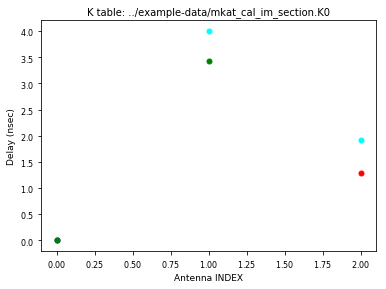

Show log 2019-06-18 09:21:23	INFO	plotcal::::	
 2019-06-18 09:21:23	INFO	plotcal::::+	##########################################
 2019-06-18 09:21:23	INFO	plotcal::::+	##### Begin Task: plotcal #####
 2019-06-18 09:21:23	INFO	plotcal::::	plotcal(caltable="../example-data/mkat_cal_im_section.K0",xaxis="antenna",yaxis="delay",poln="",field="",
 2019-06-18 09:21:23	INFO	plotcal::::+ antenna="",spw="",timerange="",subplot=111,overplot=False,
 2019-06-18 09:21:23	INFO	plotcal::::+ clearpanel="Auto",iteration="",plotrange=[],showflags=False,plotsymbol="o",
 2019-06-18 09:21:23	INFO	plotcal::::+ plotcolor="blue",markersize=5.0,fontsize=10.0,showgui=True,figfile="")
 2019-06-18 09:21:23	INFO	tableplot::setgui	Switching to GUI mode. All current plots will be reset.
 2019-06-18 09:21:23	INFO	plotcal::createCalTab Detected a NewCalTable!
 2019-06-18 09:21:23	INFO	FlagVersion::saveFlagVersion	Now get the data
 2019-06-18 09:21:23	INFO	FlagVersion::saveFlagVersion	Done Processing data ... 
 2019-06-18 09:21:24	INFO	plotcal::::	##### End Task: plotcal #####
 2019-06-18 09:21:24	INFO	plotcal::::+	##########################################

In [72]:
plotcal(caltable = ktable0, xaxis = 'antenna', yaxis = 'delay')

In [71]:
# Solve for the bandpass response -- complex gain as a function of channel across the passband.
bandpass(vis=msfile,
         caltable=btable0,
         field=b_cal,
         refant=ref_ant,
         solnorm=True,
         combine='scan',
         solint='inf',
         bandtype='B',
         minsnr=5,
         gaintable=[ktable0],
         interp=['nearest', 'nearest'])

Show log 2019-06-18 09:03:39	INFO	bandpass::::	
 2019-06-18 09:03:39	INFO	bandpass::::+	##########################################
 2019-06-18 09:03:39	INFO	bandpass::::+	##### Begin Task: bandpass #####
 2019-06-18 09:03:39	INFO	bandpass::::	bandpass(vis="../example-data/mkat_cal_im_section.ms",caltable="../example-data/mkat_cal_im_section.B0",field="PKS1934-63",spw="",intent="",
 2019-06-18 09:03:39	INFO	bandpass::::+ selectdata=True,timerange="",uvrange="",antenna="",scan="",
 2019-06-18 09:03:39	INFO	bandpass::::+ observation="",msselect="",solint="inf",combine="scan",refant="m010",
 2019-06-18 09:03:39	INFO	bandpass::::+ minblperant=4,minsnr=5,solnorm=True,bandtype="B",smodel=[],
 2019-06-18 09:03:39	INFO	bandpass::::+ append=False,fillgaps=0,degamp=3,degphase=3,visnorm=False,
 2019-06-18 09:03:39	INFO	bandpass::::+ maskcenter=0,maskedge=5,docallib=False,callib="",gaintable=['../example-data/mkat_cal_im_section.K0'],
 2019-06-18 09:03:39	INFO	bandpass::::+ gainfield=[''],interp=['nearest', 'nearest'],spwmap=[],parang=False)
 2019-06-18 09:03:39	INFO	bandpass::calibrater::open	****Using NEW VI2-driven calibrater tool****
 2019-06-18 09:03:39	INFO	bandpass::calibrater::open	Opening MS: ../example-data/mkat_cal_im_section.ms for calibration.
 2019-06-18 09:03:39	INFO	bandpass::Calibrater::	Initializing nominal selection to the whole MS.
 2019-06-18 09:03:39	INFO	bandpass::calibrater::reset	Reseting solve/apply state
 2019-06-18 09:03:39	INFO	bandpass::::	NB: bandpass automatically excludes auto-correlations.
 2019-06-18 09:03:39	INFO	calibrater::setdata	Beginning selectvis--(MSSelection version)-------
 2019-06-18 09:03:39	INFO	calibrater::reset	Reseting solve/apply state
 2019-06-18 09:03:39	INFO	Calibrater::selectvis	Performing selection on MeasurementSet
 2019-06-18 09:03:39	INFO	Calibrater::selectvis+ Selecting on field: 'PKS1934-63'
 2019-06-18 09:03:39	INFO	Calibrater::selectvis+ Selecting with TaQL: 'ANTENNA1!=ANTENNA2'
 2019-06-18 09:03:39	INFO	Calibrater::selectvis	Selection did not drop any rows
 2019-06-18 09:03:39	INFO	Calibrater::selectvis	Frequency selection: Selecting all channels in all spws.
 2019-06-18 09:03:39	INFO	calibrater::setdata	chanmode=none nchan=1 start=0 step=1 mStart='0km/s' mStep='0km/s' msSelect='ANTENNA1!=ANTENNA2'
 2019-06-18 09:03:39	INFO	calibrater::setapply	Beginning setapply--(MSSelection version)-------
 2019-06-18 09:03:39	INFO	Calibrater::setapply(type, applypar)	Arranging to APPLY:
 2019-06-18 09:03:39	INFO (K Jones: Enforcing calWt()=false for phase/delay-like terms)
 2019-06-18 09:03:39	INFO	Calibrater::setapply(type, applypar)	. K Jones: table=../example-data/mkat_cal_im_section.K0 select= interp=nearest spwmap=[-1] calWt=false
 2019-06-18 09:03:39	INFO	calibrater::setsolve	Beginning setsolve--(MSSelection version)-------
 2019-06-18 09:03:39	INFO	Calibrater::setsolve	Arranging to SOLVE:
 2019-06-18 09:03:39	INFO	Calibrater::setsolve	. B Jones: table=../example-data/mkat_cal_im_section.B0 append=false solint=inf,none refantmode='flex' refant='m010' minsnr=5 apmode=AP solnorm=true normtype=MEAN
 2019-06-18 09:03:39	INFO	calibrater::solve	Beginning solve-----------------------------
 2019-06-18 09:03:39	INFO	Calibrater::solve	The following calibration terms are arranged for apply:
 2019-06-18 09:03:39	INFO	Calibrater::solve	. K Jones: table=../example-data/mkat_cal_im_section.K0 select= interp=nearest spwmap=[-1] calWt=false
 2019-06-18 09:03:39	INFO	Calibrater::solve	The following calibration term is arranged for solve:
 2019-06-18 09:03:39	INFO	Calibrater::solve	. B Jones: table=../example-data/mkat_cal_im_section.B0 append=false solint=inf,none refantmode='flex' refant='m010' minsnr=5 apmode=AP solnorm=true normtype=MEAN
 2019-06-18 09:03:39	INFO	Calibrater::solve	For solint = inf, found 1 solution intervals.
 2019-06-18 09:03:39	INFO	Calibrater::solve Found good B Jones solutions in 0 solution intervals.
 2019-06-18 09:03:39	INFO	Calibrater::solve	No output calibration table wri

#### Apply calibration